## ML models

This notebook trains the following ML models:

1. Logistic Regressor
2. Decision Tree
3. Support-Vector Machine
4. K-Nearest Neighbours
5. Random Forests

as well as two boosting methods:

1. Extreme Gradient Boosting Machine
2. Light Gradient Boosting Machine

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import (LGBMClassifier as lgb, plot_importance)
from xgboost import XGBClassifier as xgb

from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, classification_report, mean_squared_error, roc_auc_score, confusion_matrix)
from sklearn.model_selection import (cross_validate, RepeatedStratifiedKFold, cross_val_score)
import optuna

In [5]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=42)

In [21]:
data_dir = '../data/Gaia DR3/gaia_lm_m_stars.parquet'

In [7]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,466475508969557888,18411.494141,3.5385,-0.3139,B,M,"[1.4043112e-15, 1.3886055e-15, 1.3119094e-15, ..."
1,3325513363920961408,16151.836914,3.7164,0.0395,B,M,"[1.4678052e-15, 1.3982165e-15, 1.3334084e-15, ..."
2,3375508943611375488,18823.841797,3.4316,0.2918,B,M,"[1.0764202e-15, 1.0605224e-15, 1.0162869e-15, ..."
3,4063973032805550592,15295.044922,3.4026,0.0999,G,M,"[9.53517e-16, 9.214246e-16, 8.3622285e-16, 7.9..."
4,454379128715344896,13149.229492,3.8305,-0.9505,B,LM,"[6.8294334e-16, 6.693247e-16, 6.1780524e-16, 5..."


In [8]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,466475508969557888,M,"[1.4043112e-15, 1.3886055e-15, 1.3119094e-15, ..."
1,3325513363920961408,M,"[1.4678052e-15, 1.3982165e-15, 1.3334084e-15, ..."
2,3375508943611375488,M,"[1.0764202e-15, 1.0605224e-15, 1.0162869e-15, ..."
3,4063973032805550592,M,"[9.53517e-16, 9.214246e-16, 8.3622285e-16, 7.9..."
4,454379128715344896,LM,"[6.8294334e-16, 6.693247e-16, 6.1780524e-16, 5..."


In [9]:
df = shuffle(df)

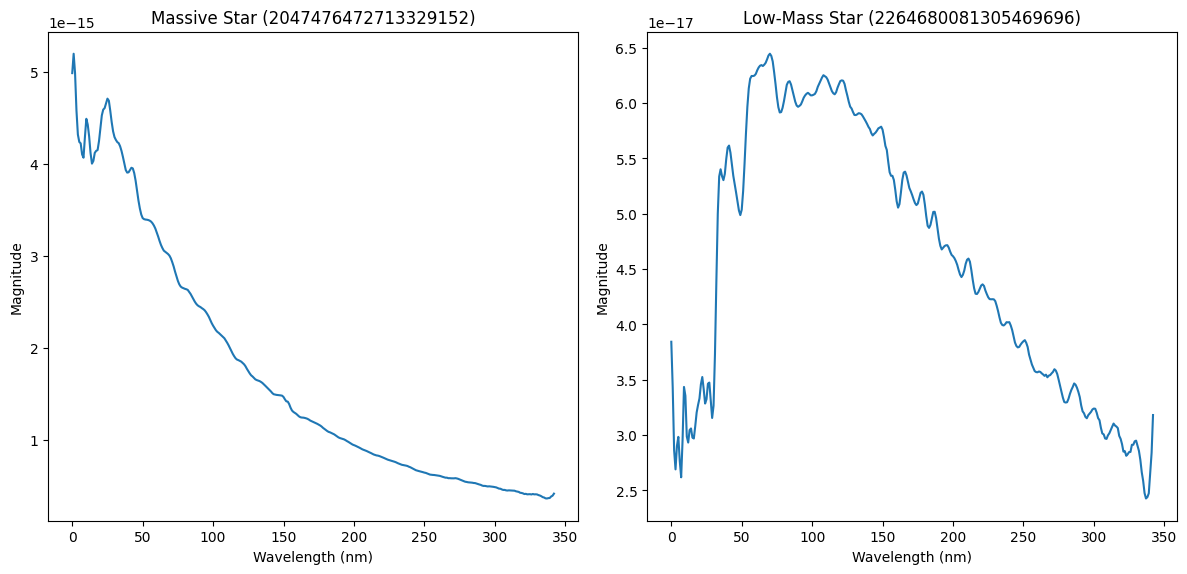

In [10]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [11]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 17627
Number of bins in each spectra: 343
In the dataset, we have 11026 spectra for low mass stars and 6601 spectra for high mass stars.


In [12]:
X = np.vstack(df['flux'])
y = np.vstack(df['Cat'])

y = np.where(y == 'M', 1, y)
y = np.where(y == 'LM', 0, y)

y = y.astype(int)

In [13]:
# L2 normalization

norm = np.linalg.norm(X,keepdims=True)
X = X/norm

In [14]:
split = 0.8

train_size = int(split * num_samples)

x_train, x_test = np.split(X, [train_size])
y_train, y_test = np.split(y, [train_size])

In [15]:
print("The dataset is divided into", len(x_train), "training samples and", len(x_test),"testing samples.")

The dataset is divided into 14101 training samples and 3526 testing samples.


## Logistic Regression

In [20]:
model = LogisticRegression()
model.fit(x_train, y_train.squeeze(1))

LogisticRegression()

In [21]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      2226
           1       0.00      0.00      0.00      1300

    accuracy                           0.63      3526
   macro avg       0.32      0.50      0.39      3526
weighted avg       0.40      0.63      0.49      3526



d:\projects\research\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\research\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\research\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Decision Trees

In [22]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train.squeeze(1))

DecisionTreeClassifier()

In [23]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2226
           1       0.91      0.88      0.90      1300

    accuracy                           0.93      3526
   macro avg       0.92      0.92      0.92      3526
weighted avg       0.93      0.93      0.93      3526



## Random Forest

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1 , 50)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    rkf = RepeatedStratifiedKFold(n_splits = 5)
    score = cross_val_score(model, x_train, y_train.squeeze(1), cv=rkf, scoring='accuracy')

    return score


study = optuna.create_study(direction='maximize', study_name='xgb_model_training')
study.optimize(objective, n_trials=100)

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train.squeeze(1))

In [ ]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2226
           1       0.93      0.94      0.94      1300

    accuracy                           0.95      3526
   macro avg       0.95      0.95      0.95      3526
weighted avg       0.95      0.95      0.95      3526



## Support-Vector Machines

In [28]:
model = SVC()
model.fit(x_train, y_train.squeeze(1))

SVC()

In [29]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2226
           1       0.88      0.59      0.71      1300

    accuracy                           0.82      3526
   macro avg       0.84      0.77      0.79      3526
weighted avg       0.83      0.82      0.81      3526



## K-Nearest Neighbours

In [31]:
model = KNeighborsClassifier()
model.fit(x_train, y_train.squeeze(1))

KNeighborsClassifier()

In [32]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2226
           1       0.92      0.96      0.94      1300

    accuracy                           0.95      3526
   macro avg       0.95      0.96      0.95      3526
weighted avg       0.96      0.95      0.96      3526



## Light Gradient Boosting Machine

In [16]:
model = lgb(n_estimators=1200, random_state=42, learning_rate = 0.01,reg_lambda=50, min_child_samples=2400, num_leaves=95, colsample_bytree=0.19, max_bins=511)
model.fit(x_train, y_train.squeeze(1))

[LightGBM] [Info] Number of positive: 5249, number of negative: 8852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175273
[LightGBM] [Info] Number of data points in the train set: 14101, number of used features: 343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372243 -> initscore=-0.522606
[LightGBM] [Info] Start training from score -0.522606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(colsample_bytree=0.19, learning_rate=0.01, max_bins=511,
               min_child_samples=2400, n_estimators=1200, num_leaves=95,
               random_state=42, reg_lambda=50)

In [19]:
y_pred = model.predict(x_test)
report = classification_report(y_pred, y_test)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2045
           1       0.96      0.88      0.92      1481

    accuracy                           0.93      3526
   macro avg       0.94      0.93      0.93      3526
weighted avg       0.94      0.93      0.93      3526



## Extreme Gradient Boosting Machine

In [ ]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree','gblinear']),
        'device': 'cuda',
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise','lossguide']),
    }